# Training Kentekenplaat Detectie
in dit notebook kan een Mask R-CNN model worden getrained voor het detecteren van kentekenplaten. 

In [1]:
%load_ext pycodestyle_magic

In [2]:
%flake8_on

In [3]:
# all imports
from os import listdir
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from numpy import expand_dims
from numpy import mean
import mrcnn.model as modellib
from mrcnn.config import Config
from mrcnn.model import MaskRCNN
from mrcnn.utils import Dataset
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes
import keras
from keras import backend as K
import tensorflow as tf
import cv2
from Utility.LicensePlateClass import PlateDataset
import math

Using TensorFlow backend.
c:\users\midni\appdata\local\programs\python\python37\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 7.1.0. Several security issues (CVE-2020-11538, CVE-2020-10379, CVE-2020-10994, CVE-2020-10177) have been fixed in pillow 7.1.0 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# Data Inladen
De data die eerder is aangemaakt moet eerst correct worden ingeladen. De 'train_max' parameter moet men zelf aanpassen afhankelijk van de dataset grootte.

In [6]:
# train set
train_set = PlateDataset()
train_set.load_dataset(r"./Dataset/TrainAndTest/", is_train=True, train_max=801)
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))

Train: 800


In [8]:
# test/val set
test_set = PlateDataset()
test_set.load_dataset(r"./Dataset/TrainAndTest/", is_train=False, train_max=801)
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Test: 160


Test of images goed zijn ingeladen

In [9]:
# load an image
image_id = 3
image = train_set.load_image(image_id)
print(image.shape)
# load image mask
mask, class_ids = train_set.load_mask(image_id)
print(mask.shape)

(1160, 720, 3)
(1160, 720, 1)


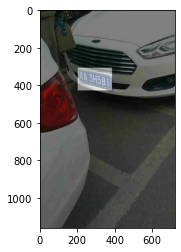

In [10]:
# plot image
plt.imshow(image)
# plot mask
plt.imshow(mask[:, :, 0], cmap='gray', alpha=0.5)
plt.show()

De data is als het goed is nu correct ingeladen.

# Model Configuratie
Nu moet het trainings model worden geconfigureert. 

In [11]:
# define a configuration for the model
class PlateConfig(Config):
    # Give the configuration a recognizable name
    NAME = "plate_cfg"
    # Number of classes (background + plates)
    NUM_CLASSES = 1 + 1
    BATCH_SIZE = 32
    # Number of training steps per epoch
    STEPS_PER_EPOCH = int(math.ceil(len(train_set.image_ids) / BATCH_SIZE))
    VALIDATION_STEPS = int(math.ceil(len(test_set.image_ids) / BATCH_SIZE))


# define plate configuruation
config = PlateConfig()

# define the model
model = MaskRCNN(mode='training', model_dir='Plate-Model', config=config)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [12]:
# define the prediction configuration
class PredictionConfig(Config):
    # define the name of the configuration
    NAME = "plate_cfg"
    # number of classes (background + kangaroo)
    NUM_CLASSES = 1 + 1
    # simplify GPU config
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1


# define inference configuration
inference_config = PredictionConfig()
# define the model
model_inference = MaskRCNN(mode='inference', model_dir='./',
                           config=inference_config)



Instructions for updating:
Use `tf.cast` instead.


In [16]:
mean_average_precision_callback = modellib.MeanAveragePrecisionCallback(model,
                                                                        model_inference,
                                                                        dataset=test_set,
                                                                        calculate_map_at_every_X_epoch=10,
                                                                        verbose=1)
# load weights (mscoco)
model.load_weights('mask_rcnn_coco.h5', by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                            "mrcnn_bbox", "mrcnn_mask"])

# Trainen 
In dit gedeelte wordt het model daadwerkelijk getraind. 
!waarschuwing! afhankelijk van de hardware van jou systeem kan dit erg lang of vrij kort duren. indien je langere tijd vast zit op epoch 1, probeer dan jupyter te herstarten omdat er wellicht een memory overload is. 

In [11]:
# train weights (output layers or 'heads')
model.train(train_set, test_set, learning_rate=config.LEARNING_RATE, 
            epochs=10, layers='heads', 
            custom_callbacks=[mean_average_precision_callback])


Starting at epoch 0. LR=0.001

Checkpoint Path: Plate-Model\plate_cfg20210410T0103\mask_rcnn_plate_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4     

c:\users\bart jansen\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\bart jansen\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
c:\users\bart jansen\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "






Epoch 1/10
25/25 [==============================] - 42s 2s/step - loss: 2.6687 - rpn_class_loss: 0.0343 - rpn_bbox_loss: 1.2096 - mrcnn_class_loss: 0.0913 - mrcnn_bbox_loss: 0.7520 - mrcnn_mask_loss: 0.5815 - val_loss: 1.1860 - val_rpn_class_loss: 0.0109 - val_rpn_bbox_loss: 0.1685 - val_mrcnn_class_loss: 0.0723 - val_mrcnn_bbox_loss: 0.4336 - val_mrcnn_mask_loss: 0.5007

Epoch 2/10
25/25 [==============================] - 32s 1s/step - loss: 1.2216 - rpn_class_loss: 0.0308 - rpn_bbox_loss: 0.3314 - mrcnn_class_loss: 0.0370 - mrcnn_bbox_loss: 0.4026 - mrcnn_mask_loss: 0.4198 - val_loss: 0.7858 - val_rpn_class_loss: 0.0120 - val_rpn_bbox_loss: 0.1199 - val_mrcnn_class_loss: 0.0218 - val_mrcnn_bbox_loss: 0.2649 - val_mrcnn_mask_loss: 0.3672
Epoch 3/10
25/25 [==============================] - 32s 1s/step - loss: 0.9418 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2730 - mrcnn_class_loss: 0.0226 - mrcnn_bbox_loss: 0.3062 - mrcnn_mask_loss: 0.3289 - val_loss: 0.8560 - val_rpn_class_loss:

2:69: W291 trailing whitespace
3:39: W291 trailing whitespace
6:1: E265 block comment should start with '# '
7:1: E265 block comment should start with '# '
8:1: E265 block comment should start with '# '
9:1: E265 block comment should start with '# '


mAP at epoch 10 is: 0.9427083333333333


# Evaluatie
evaluatie van het model om te zien hoe hoog deze scoort na training. 

In [3]:
# calculate the mAP for a model on a given dataset
def evaluate_model(dataset, model, cfg):
    """
    :parameter dataset: dataset we're evaluating on
    :parameter model: model we're evaluating
    :parameter cfg: configuration file for the model
    :type dataset: PlateDataset
    :type model: .h file
    :type cfg: PredictionConfig
    :return mAP: mean absolute precision
    :rtype mAP: float
    """
    APs = list()
    for image_id in dataset.image_ids:
        # load image, bounding boxes and masks for the image id
        image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)
        # extract results for first sample
        r = yhat[0]
        # calculate statistics, including AP
        AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, r["rois"], r["class_ids"], r["scores"], r['masks'])
        # store
        APs.append(AP)
    # calculate the mean AP across all images
    mAP = mean(APs)
    return mAP

In [12]:
# create config
eval_config = PredictionConfig()
# define the model
model = MaskRCNN(mode='inference', model_dir='./', config=eval_config)
# load model weights
model.load_weights('mask_rcnn_plate_cfg_0100.h5', by_name=True)

In [13]:
# evaluate model on training dataset
train_mAP = evaluate_model(train_set, model, eval_config)
print("Train mAP: %.3f" % train_mAP)

Train mAP: 0.978


In [15]:
# evaluate model on test dataset
test_mAP = evaluate_model(test_set, model, eval_config)
print("Test mAP: %.3f" % test_mAP)

Test mAP: 0.975


In [2]:
def plot_actual_vs_predicted(dataset, model, cfg, n_images=5):
    """
    :parameter dataset: dataset we're predicting for
    :parameter model: model used for detection
    :parameter cfg: configuration for the model
    :parameter n_images: amount of images that will be predicted, defaults to 5
    :type dataset: PlateDataset
    :type model: .h file
    :type cfg: PredictionConfig
    :type n_images: int
    """
    # load image and mask
    for i in range(n_images):
        # load the image and mask
        image = dataset.load_image(i)
        mask, _ = dataset.load_mask(i)
        # convert pixel values (e.g. center)
        scaled_image = mold_image(image, cfg)
        # convert image into one sample
        sample = expand_dims(scaled_image, 0)
        # make prediction
        yhat = model.detect(sample, verbose=0)[0]
        # define subplot
        plt.subplot(n_images, 2, i*2+1)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Actual')
        # plot masks
        for j in range(mask.shape[2]):
            plt.imshow(mask[:, :, j], cmap='gray', alpha=0.3)
        # get the context for drawing boxes
        plt.subplot(n_images, 2, i*2+2)
        # plot raw pixel data
        plt.imshow(image)
        plt.title('Predicted')
        ax = plt.gca()
        # plot each box
        for box in yhat['rois']:
            # get coordinates
            y1, x1, y2, x2 = box
            # calculate width and height of the box
            width, height = x2 - x1, y2 - y1
            # create the shape
            rect = Rectangle((x1, y1), width, height, fill=False, color='red')
            # draw the box
            ax.add_patch(rect)
    # show the figure
    plt.show()

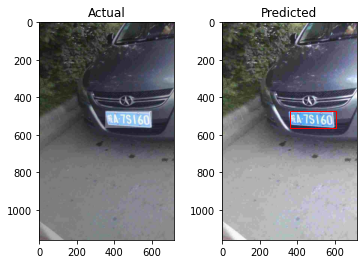

In [17]:
# plot predictions for train dataset
plot_actual_vs_predicted(test_set, model, eval_config, 1)

# Bronnen
Brownlee, J. (2020, September 1). How to Train an Object Detection Model with Keras. Machine Learning Mastery. https://machinelearningmastery.com/how-to-train-an-object-detection-model-with-keras/

Matterport, M. (2018, March 20). matterport/Mask_RCNN. GitHub. https://github.com/matterport/Mask_RCNN